# Cross-slope section

EO: this is an extension of the cross slope section notebook by Wilma, but with an additional panel for wind stress, and potential density contours

This notebook gives an example on how to obtain a section through gridded data. We use the __[function](https://unidata.github.io/MetPy/latest/examples/cross_section.html#sphx-glr-examples-cross-section-py)__ `metpy.interpolate.cross_section` to do so. 
In this example we plot the along-slope velocity component across the Antarctic continental shelf break. In order to calculate the along-slope velocity component, we will need to calculate the topographic gradient first, which we do with the help of the `xgcm` __[module](https://xgcm.readthedocs.io/en/latest/)__. 

Load modules

In [1]:
# Standard modules
import cosima_cookbook as cc
from cosima_cookbook import explore

from dask.distributed import Client
import numpy as np
import xarray as xr

# For gradient calculation 
# (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm

# Load metpy module to obtain cross section 
# (Select the conda/analusis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm

In [2]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Start a cluster with multiple cores

In [3]:
client = Client(local_directory = '/scratch/v45/qo9901/') 
client

Client Scheduler: tcp://127.0.0.1:33725 Dashboard: /proxy/39261/status,Cluster Workers: 4 Cores: 8 Memory: 32.00 GiB


Nominate a database from which to load the data and define an experiment

In [4]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

In [5]:
depth = 3000

In [6]:
#Pick shelf coordinates
#warm
shelf_coord = (-74, -115+100)
deep_coord  = (-70.5, -115+100)
shelf_coord = (-66.5, -68.5+100)
deep_coord  = (-65, -74+100)
shelf_coord = (-62, -60+100)
deep_coord  = (-56.5, -59+100)

#dense
shelf_coord = (-67, -58+100)
deep_coord  = (-67, -52+100)


Load velocity and bathymetry data

In [8]:
# Select data in the southern Southern Ocean
lat_slice  = slice(-80, -59)
# We will use an annual average from one year in the RYF run
start_time = '2086-01-01'
end_time   = '2086-12-31'

# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()

# Import velocity data (upper 500 m)
u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).mean('time')
u = u.sel(yu_ocean=lat_slice).sel(st_ocean=slice(0,depth))
v = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc")
v = v.sel(time=slice(start_time,end_time)).mean('time')
v = v.sel(yu_ocean=lat_slice).sel(st_ocean=slice(0,depth))

In [9]:
u

<xarray.DataArray 'u' (st_ocean: 60, yu_ocean: 484, xu_ocean: 3600)>
dask.array<getitem, shape=(60, 484, 3600), dtype=float32, chunksize=(7, 274, 400), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -79.99 -79.95 -79.9 ... -59.11 -59.06 -59.01

In [10]:
ee = explore.ExperimentExplorer(session=session, experiment='01deg_jra55v13_ryf9091')
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

Get out all variables to avoid memory errors, pot_temp and pot_rho_1.

In [37]:
pot_rho_1 = cc.querying.getvar(expt, 'pot_rho_1', session, start_time='2179-01-01', end_time='2180-01-01',  ncfile="ocean_daily_3d_pot_rho_1.nc")

In [38]:
pot_rho_1 = pot_rho_1.mean(dim = 'time')
pot_rho_1 = pot_rho_1.sel(yt_ocean = lat_slice).sel(st_ocean=slice(0,depth))
pot_rho_1

<xarray.DataArray 'pot_rho_1' (st_ocean: 60, yt_ocean: 483, xt_ocean: 3600)>
dask.array<getitem, shape=(60, 483, 3600), dtype=float32, chunksize=(7, 273, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -59.14 -59.08 -59.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03

In [39]:
pot_temp = cc.querying.getvar(expt, 'pot_temp', session,  start_time=start_time, end_time=end_time, ncfile="ocean.nc")

In [40]:
pot_temp = pot_temp.mean(dim = 'time')
pot_temp = pot_temp.sel(yt_ocean = lat_slice).sel(st_ocean=slice(0,depth))
pot_temp

<xarray.DataArray 'pot_temp' (st_ocean: 60, yt_ocean: 483, xt_ocean: 3600)>
dask.array<getitem, shape=(60, 483, 3600), dtype=float32, chunksize=(7, 273, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -59.14 -59.08 -59.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03

In [41]:
tau_x = cc.querying.getvar(expt, 'tau_x', session, start_time=start_time, end_time=end_time, ncfile="ocean_month.nc")
tau_x = tau_x.sel(time=slice(start_time,end_time)).mean('time')
tau_x = tau_x.sel(yu_ocean=lat_slice)#.sel(st_ocean=slice(0,500))
tau_x

<xarray.DataArray 'tau_x' (yu_ocean: 484, xu_ocean: 3600)>
dask.array<getitem, shape=(484, 3600), dtype=float32, chunksize=(484, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -79.99 -79.95 -79.9 ... -59.11 -59.06 -59.01

In [42]:
tau_y = cc.querying.getvar(expt, 'tau_y', session, start_time=start_time, end_time=end_time, ncfile="ocean_month.nc")
tau_y = tau_y.sel(time=slice(start_time,end_time)).mean('time')
tau_y = tau_y.sel(yu_ocean=lat_slice)#.sel(st_ocean=slice(0,500))
tau_y

<xarray.DataArray 'tau_y' (yu_ocean: 484, xu_ocean: 3600)>
dask.array<getitem, shape=(484, 3600), dtype=float32, chunksize=(484, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -79.99 -79.95 -79.9 ... -59.11 -59.06 -59.01

### Along-slope velocity

We calculate the along-slope velocity component by projecting the velocity field to the tangent vector, $u_{along} = \boldsymbol{u \cdot \hat{t}$, and the cross-slope component by projecting to the normal vector, $v_{cross} = \boldsymbol{u \cdot \hat{n}}$. The schematic below defines the unit normal normal and tangent vectors for a given bathymetric contour, $\boldsymbol{n}$ and $\boldsymbol{t}$ respectively. 

![Sketch of topographic gradient](images/topographic_gradient_sketch.png)

Accordingly, the code below calculates the along-slope velocity component as

$$ u_{along} = (u,v) \boldsymbol{\cdot} \left(\frac{h_y}{|\nabla h|} , -\frac{h_x}{|\nabla h|}\right) = 
u \frac{h_y}{|\nabla h|} - v \frac{h_x}{|\nabla h|}, $$  

and similarly the cross-slope velocity component as

$$ v_{cross} = (u,v) \boldsymbol{\cdot} \left(\frac{h_x}{|\nabla h|} , \frac{h_y}{|\nabla h|}\right)  = 
u \frac{h_x}{|\nabla h|} + v \frac{h_y}{|\nabla h|}.$$ 


We need the derivatives of the bathymetry which we compute using the `xgcm` functionality.

In [43]:
# Load model grid information
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')
# In meridional direction, we need to specify what happens at the boundary
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

Calculate along-slope velocity component

In [44]:
# Along-slope velocity
u_along = u*dhu_dy/topographic_slope_magnitude - v*dhu_dx/topographic_slope_magnitude
tau_along = tau_x*dhu_dy/topographic_slope_magnitude - tau_y*dhu_dx/topographic_slope_magnitude

# Load the data
#u_along = u_along.load()

# Similarly, we can calculate the cross-slope velocity:
#v_cross = u*dhu_dx/topographic_slope_magnitude + v*dhu_dy/topographic_slope_magnitude

In [45]:
u_along

<xarray.DataArray (st_ocean: 60, yu_ocean: 484, xu_ocean: 3600)>
dask.array<sub, shape=(60, 484, 3600), dtype=float32, chunksize=(7, 274, 400), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -79.99 -79.95 -79.9 ... -59.11 -59.06 -59.01

In [46]:
# Create dataset
ds_tau= xr.Dataset({"tau_along": tau_along, "lat": tau_along.yu_ocean, "lon": tau_along.xu_ocean})
# Rename coordinate names
ds_tau = ds_tau.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
ds_tau['x'] = ds_tau['x']+100
ds_tau['x'].attrs = tau_along['xu_ocean'].attrs

# MetPy parsing
tau_parsed = ds_tau.metpy.parse_cf('tau_along', coordinates={'y': 'y', 'x': 'x'})

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


In [47]:
# Create dataset
ds = xr.Dataset({"u_along": u_along, "lat": u.yu_ocean, "lon": u.xu_ocean, "hu": hu})
# Rename coordinate names
ds = ds.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
ds['x'] = ds['x']+100
ds['x'].attrs = u['xu_ocean'].attrs

# MetPy parsing
u_parsed = ds.metpy.parse_cf('u_along', coordinates={'y': 'y', 'x': 'x'})

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


In [48]:
# Define number of points you want to interpolate
step_no = 400
# Finally, interpolate gridded data onto the section
tau_section = cross_section(tau_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps = step_no, interp_type='linear')

#.set_coords(('y','x'))#, interp_type='linear')
u_section = cross_section(u_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps = step_no, interp_type='linear')



In [49]:
# Radius of the Earth in km
r = 6371
# Difference between points in lat/lon space
dlon = deep_coord[1]-shelf_coord[1]
dlat = deep_coord[0]-shelf_coord[0]
# Calculate distance in km between the two end points
distance_endpoints = r * np.deg2rad(np.sqrt(dlat**2 + (dlon*np.cos(np.deg2rad(np.mean([shelf_coord[0],deep_coord[0]]))))**2))
# Create array with length of step_no
distance_in_km = np.linspace(0, distance_endpoints, step_no)
# Repeat by the number of depth levels
distance_in_km = np.tile(distance_in_km, (len(u_section.st_ocean), 1))

### interplolate for pot_rho_1 and pot_temp
We need a new grid which includes the depth coordinate --> grid_depth

In [50]:
# Load model grid information with depth
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds = xr.merge([u.sel(yu_ocean=lat_slice).sel(st_ocean=slice(0,depth)), grid.sel(yu_ocean=lat_slice).sel(yt_ocean=lat_slice)])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid_depth = xgcm.Grid(ds, periodic=['X'])
grid_depth

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> outer
  * outer    yu_ocean --> center

In [51]:
ds

<xarray.Dataset>
Dimensions:     (st_ocean: 60, time: 1, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 483, yu_ocean: 484)
Coordinates:
  * st_ocean    (st_ocean) float64 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
  * xu_ocean    (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean    (yu_ocean) float64 -79.99 -79.95 -79.9 ... -59.11 -59.06 -59.01
  * xt_ocean    (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean    (yt_ocean) float64 -79.97 -79.93 -79.88 ... -59.14 -59.08 -59.03
  * time        (time) object 1900-04-01 00:00:00
    geolon_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(483, 3600), meta=np.ndarray>
    geolat_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(483, 3600), meta=np.ndarray>
    geolon_c    (yu_ocean, xu_ocean) float32 dask.array<chunksize=(484, 3600), meta=np.ndarray>
    geolat_c    (yu_ocean, xu_ocean) float32 dask.array<chunksize=(484, 3600), meta=np.ndarray>
Data variables:
    u           (st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(7, 274, 400), meta=np.ndarray>
    ht          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(483, 3600), meta=np.ndarray>
    hu          (yu_ocean, xu_ocean) float32 dask.array<chunksize=(484, 3600), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(483, 3600), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(483, 3600), meta=np.ndarray>
    dxu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(484, 3600), meta=np.ndarray>
    dyu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(484, 3600), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(483, 3600), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(484, 3600), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(483, 3600), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 dask.array<chunksize=(484, 3600), meta=np.ndarray>
    drag_coeff  (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 484, 3600), meta=np.ndarray>

In [52]:
pot_rho_1 = grid_depth.interp(grid_depth.interp(pot_rho_1, axis = 'X') , axis = 'Y', boundary = 'extend')#.sel(yu_ocean=lat_slice).sel(st_ocean=slice(0,depth))


# Create dataset
ds_pot_rho_1= xr.Dataset({"pot_rho_1": pot_rho_1, "lat": pot_rho_1.yu_ocean, "lon": pot_rho_1.xu_ocean})
# Interpolate to xu_ocean and yu_ocean
# Rename coordinate names
ds_pot_rho_1 = ds_pot_rho_1.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
ds_pot_rho_1['x'] = ds_pot_rho_1['x']+100

ds_pot_rho_1['x'].attrs = pot_rho_1['xu_ocean'].attrs

# MetPy parsing
pot_rho_1_parsed = ds_pot_rho_1.metpy.parse_cf('pot_rho_1', coordinates={'y': 'y', 'x': 'x'})
pot_rho_1_section = cross_section(pot_rho_1_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps = step_no, interp_type='linear')

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


In [54]:
pot_rho_1_section

<xarray.DataArray 'pot_rho_1' (st_ocean: 60, index: 400)>
dask.array<dask_aware_interpnd, shape=(60, 400), dtype=float32, chunksize=(7, 400), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
    metpy_crs  object Projection: latitude_longitude
    x          (index) float64 42.0 42.02 42.03 42.05 ... 47.95 47.97 47.98 48.0
    y          (index) float64 -67.0 -67.0 -67.0 -67.0 ... -67.0 -67.0 -67.0
  * index      (index) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399

In [56]:
pot_temp = grid_depth.interp(grid_depth.interp(pot_temp, axis = 'X') , axis = 'Y', boundary = 'extend')#.sel(yu_ocean=lat_slice).sel(st_ocean=slice(0,depth))

# Create dataset
ds_pot_temp= xr.Dataset({"pot_temp": pot_temp, "lat": pot_temp.yu_ocean, "lon": pot_temp.xu_ocean})
# Interpolate to xu_ocean and yu_ocean
# Rename coordinate names
ds_pot_temp = ds_pot_temp.rename({'xu_ocean': 'x', 'yu_ocean': 'y'})
# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
ds_pot_temp['x'] = ds_pot_temp['x']+100

ds_pot_temp['x'].attrs = pot_temp['xu_ocean'].attrs

# MetPy parsing
pot_temp_parsed = ds_pot_temp.metpy.parse_cf('pot_temp', coordinates={'y': 'y', 'x': 'x'})
pot_temp_section = cross_section(pot_temp_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps = step_no, interp_type='linear')

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


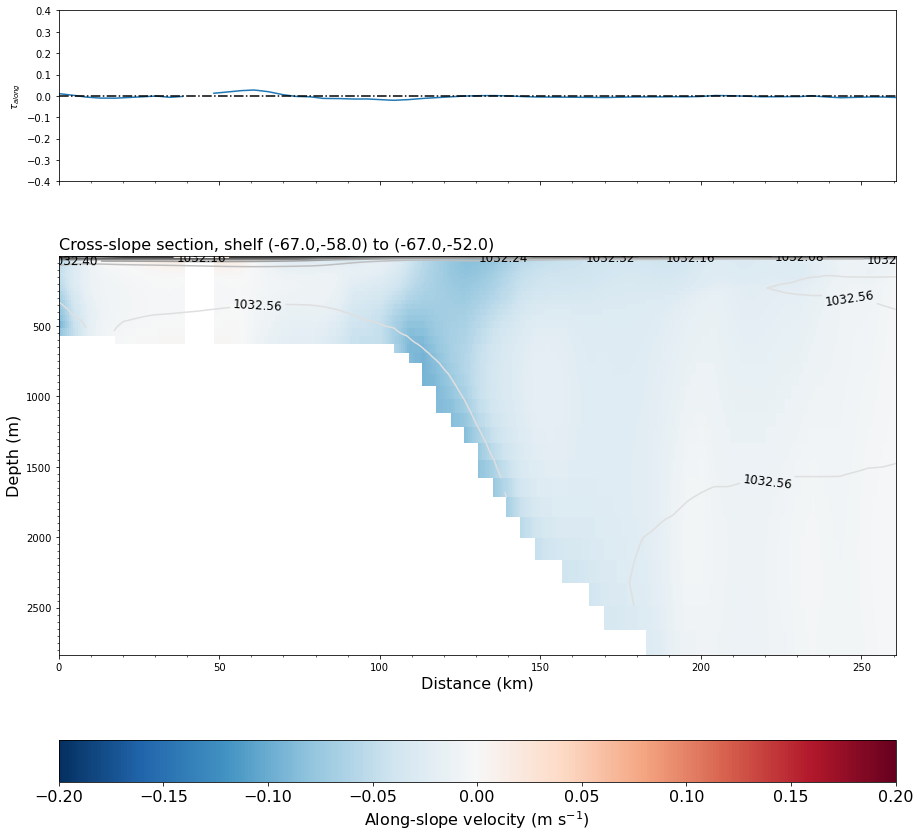

In [26]:
fig, axs = plt.subplots(nrows = 2, gridspec_kw={'height_ratios': [3, 10]}, figsize=(15, 15), sharex = True)
ft_size = 16


axs[0].plot(distance_in_km[0,:],tau_section)
axs[0].set_ylabel(r'$\tau_{along}$')
axs[0].plot(distance_in_km[0,:],np.zeros(len(distance_in_km[0,:])),'k-.')
axs[0].set_ylim([-0.4,0.4])
#axs[0].set_xlim([0,350])

axs[1].set_title('Cross-slope section, warm shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100), fontsize=ft_size, loc='left')
axs[1].set_title('Cross-slope section, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100), fontsize=ft_size, loc='left')

cmesh = axs[1].pcolormesh(distance_in_km, u_section.st_ocean, u_section,vmin = -0.2, vmax = 0.2,cmap = 'RdBu_r')
# Colorbar
cbar = plt.colorbar(cmesh, orientation = 'horizontal')
cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size)

cs = axs[1].contour(distance_in_km[0,:], pot_rho_1_section.st_ocean, pot_rho_1_section, cmap = 'gray')
axs[1].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

# Axes
plt.gca().invert_yaxis()
plt.xlabel('Distance (km)', fontsize=ft_size)
plt.ylabel('Depth (m)', fontsize=ft_size)
axs[1].xaxis.set_minor_locator(MultipleLocator(10))
axs[1].yaxis.set_minor_locator(MultipleLocator(50))


#plt.savefig('cross_slope_mixedplot_circumpolar(%i,%i)to(%i,%i)_depth%i.jpg' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100,depth))

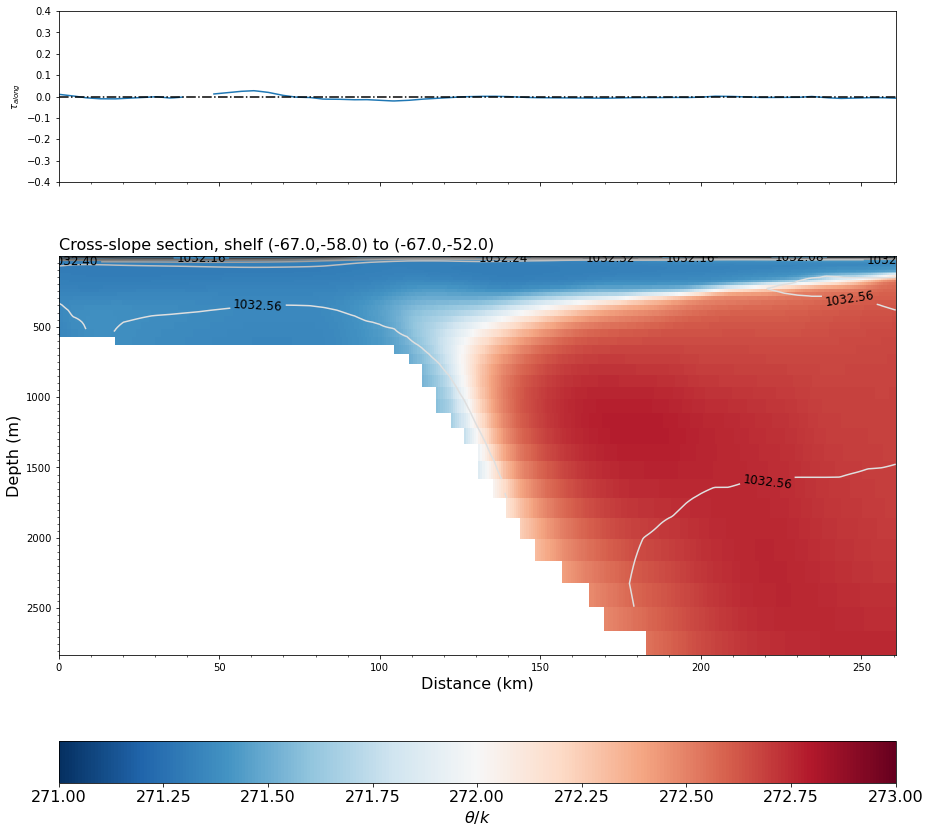

In [69]:
fig, axs = plt.subplots(nrows = 2, gridspec_kw={'height_ratios': [3, 10]}, figsize=(15, 15), sharex = True)
ft_size = 16


axs[0].plot(distance_in_km[0,:],tau_section)
axs[0].set_ylabel(r'$\tau_{along}$')
axs[0].plot(distance_in_km[0,:],np.zeros(len(distance_in_km[0,:])),'k-.')
axs[0].set_ylim([-0.4,0.4])
#axs[0].set_xlim([0,350])

axs[1].set_title('Cross-slope section, warm shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100), fontsize=ft_size, loc='left')
axs[1].set_title('Cross-slope section, shelf (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100), fontsize=ft_size, loc='left')

cmesh = axs[1].pcolormesh(distance_in_km, pot_temp_section.st_ocean.sel(st_ocean=slice(0,5000)).values, pot_temp_section.sel(st_ocean=slice(0,5000)).values, vmin = 271, vmax = 273,cmap = 'RdBu_r')
# Colorbar
cbar = plt.colorbar(cmesh,orientation = 'horizontal')
cbar.set_label( r'$\theta$ / K', fontsize=ft_size)
cbar.ax.tick_params(labelsize=ft_size)

cs = axs[1].contour(distance_in_km[0,:], pot_rho_1_section.st_ocean, pot_rho_1_section, cmap = 'gray')
axs[1].clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

# Axes
plt.gca().invert_yaxis()
plt.xlabel('Distance (km)', fontsize=ft_size)
plt.ylabel('Depth (m)', fontsize=ft_size)
axs[1].xaxis.set_minor_locator(MultipleLocator(10))
axs[1].yaxis.set_minor_locator(MultipleLocator(50))
#plt.savefig('cross_slope_temp_density_(%i,%i)to(%i,%i).jpg' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100))


Finally calculate the distance along the transect (for plotting purposes)

In [ ]:
# Radius of the Earth in km
r = 6371
# Difference between points in lat/lon space
dlon = deep_coord[1]-shelf_coord[1]
dlat = deep_coord[0]-shelf_coord[0]
# Calculate distance in km between the two end points
distance_endpoints = r * np.deg2rad(np.sqrt(dlat**2 + (dlon*np.cos(np.deg2rad(np.mean([shelf_coord[0],deep_coord[0]]))))**2))
# Create array with length of step_no
distance_in_km = np.linspace(0, distance_endpoints, step_no)
# Repeat by the number of depth levels
distance_in_km = np.tile(distance_in_km, (len(u_section.st_ocean), 1))

### Plotting

In [65]:
# For polar projection
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Data required for lat/lon mapping
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# Make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

# Fontsize
ft_size = 16

Map of topographic slope and location of cross-slope section

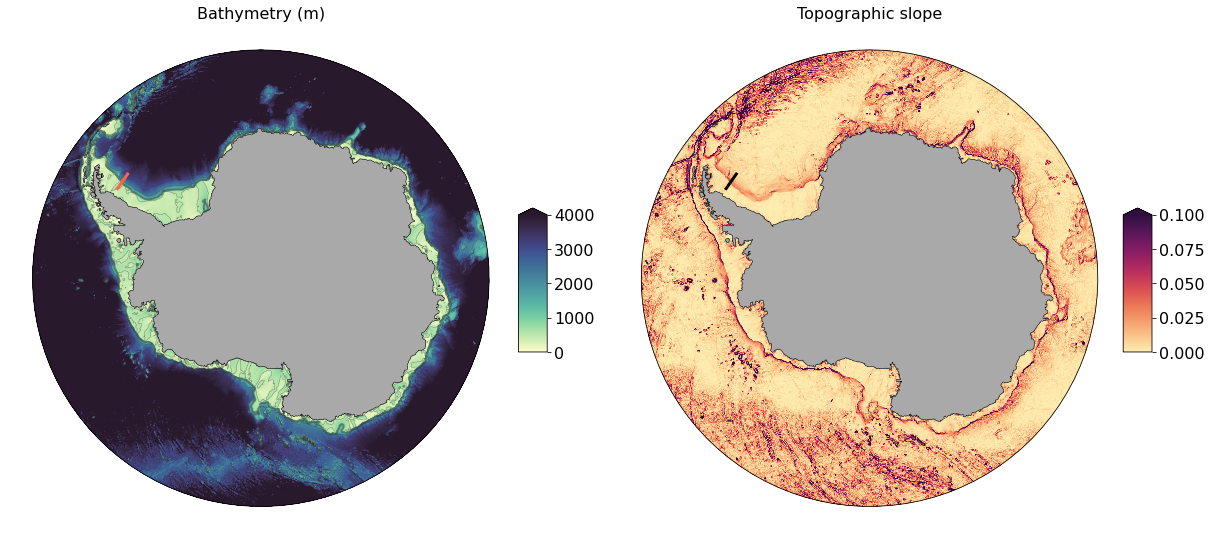

In [66]:

# For polar projection
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Data required for lat/lon mapping
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# Make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

# Fontsize
ft_size = 16
fig = plt.figure(1, figsize=(20,10))

# LEFT PANEL: bathymetry
ax0 = plt.subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax0.set_boundary(circle, transform=ax0.transAxes)
plt.title('Bathymetry (m)', fontsize=ft_size)
# Plot land
ax0.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree())
ax0.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
plt.contour(hu.xu_ocean, hu.yu_ocean, hu, levels=[500, 1000, 2000, 3000], colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5, transform=ccrs.PlateCarree())
# Plot topographic slope 
sc = ax0.pcolormesh(topographic_slope_magnitude.xu_ocean, topographic_slope_magnitude.yu_ocean, hu, cmap=cm.cm.deep, transform=ccrs.PlateCarree(), vmin=0, vmax=4000)
# Plot location of cross-slope section (East Antarctica)
plt.plot([shelf_coord[1]-100, deep_coord[1]-100], [shelf_coord[0], deep_coord[0]], color='tomato', linewidth=3, transform=ccrs.PlateCarree())
# Colorbar
cbar_ax = fig.add_axes([0.48, 0.4, 0.02, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', shrink=0.5, extend='max')
cbar.ax.tick_params(labelsize=ft_size)

# RIGHT PANEL: topographic slope
ax0 = plt.subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax0.set_boundary(circle, transform=ax0.transAxes)
plt.title('Topographic slope', fontsize=ft_size)
# Plot land
ax0.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree())
ax0.contour(xu_ocean, yu_ocean, land_mask, [0,1], colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
# Plot topographic slope 
sc = ax0.pcolormesh(topographic_slope_magnitude.xu_ocean, topographic_slope_magnitude.yu_ocean, topographic_slope_magnitude, cmap=cm.cm.matter, transform=ccrs.PlateCarree(), vmin=0, vmax=0.1)
# Plot location of cross-slope section (East Antarctica)
plt.plot([shelf_coord[1]-100, deep_coord[1]-100], [shelf_coord[0], deep_coord[0]], color='k', linewidth=3, transform=ccrs.PlateCarree())
# Colorbar
cbar_ax = fig.add_axes([0.9, 0.4, 0.02, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', shrink=0.5, extend='max')
cbar.ax.tick_params(labelsize=ft_size)